In [1]:
from keras.models import load_model
from music21.midi import translate
from music21 import pitch, note
from music21.articulations import Fingering, Articulation
from music21.stream import Stream
import numpy as np

from configs import Configs
from data_utils import DataUtil
from trainer import TrainerSetup
from image_transfer_learning import image_generator
from models import build_res_net
from utils import pickle_load
from IPython.display import Image
from IPython.core.display import HTML 

/Users/ilanfilonenko/6700/optical-music-recognition/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from inference import Inference, Configs, DataUtil

## Load configs and data_util for encoding + decoding

In [3]:
configs: Configs = \
    pickle_load('cache/{}.p'.format("configs"))
data_util: DataUtil = \
    pickle_load('cache/{}.p'.format("data_util"))
inference = Inference(configs, data_util)

## Evaluate Seq2Seq Model

In [4]:
model = load_model('cache/{}.h5'.format("model"))

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 1, 2048)      0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, 400, 666)     0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 1, 256)       524544      encoder_input[0][0]              
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 400, 256)     170752      decoder_input[0][0]              
__________________________________________________________________________________________________
e_lstm (LS

## Evaluate Encoder and Decoder Model

In [6]:
inference.encoder_model = \
    load_model('cache/{}.h5'.format("encoder_example"))
inference.decoder_model = \
    load_model('cache/{}.h5'.format("decoder_example"))

/Users/ilanfilonenko/6700/optical-music-recognition/venv/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
inference.encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 1, 2048)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 256)            524544    
_________________________________________________________________
e_lstm (LSTM)                [(None, 256), (None, 256) 525312    
Total params: 1,049,856
Trainable params: 1,049,856
Non-trainable params: 0
_________________________________________________________________


In [8]:
inference.decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, 400, 666)     0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 400, 256)     170752      decoder_input[0][0]              
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 256)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1, 256)       0                                            
__________________________________________________________________________________________________
d_lstm (LS

## Example end2end test

In [9]:
Image(url= "data/training/images/1981321.jpg", width=400, height=400)

In [10]:
resNet = build_res_net()
gen = image_generator(["data/training/images/1981321.jpg"], 1)
input_img_vector = resNet.predict_generator(gen, 1, verbose=1)

/Users/ilanfilonenko/6700/optical-music-recognition/models.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`
  output=base_model.get_layer('avg_pool').output))


1/1 [==============================] - 2s 2s/step


### Encoder Output

In [11]:
encoder_states = inference.encoder_model.predict(input_img_vector.reshape(1,1,configs.image_vec_dim))

### Decoder Start State

In [39]:
start_state = np.vstack((data_util.middle_c.reshape(1,data_util.encoding_size+1)\
           ,np.zeros((configs.L-1,data_util.encoding_size+1)))).reshape(1,configs.L,data_util.encoding_size+1)

### Decoder Output

In [40]:
output_tokens, _, _ = inference.decoder_model.predict(
    [start_state] + \
    [encoder_states[0].reshape(1, 1, configs.lstm_input_size), \
     encoder_states[1].reshape(1, 1, configs.lstm_input_size)])

### Inference

In [41]:
output_result = []
for row in output_tokens[0]:
    if np.argmax(row) == data_util.encoding_size:
        break
    else:
        pitch_indx = np.argmax(row[:-1][:inference.indx])
        duration_indx = np.argmax(row[:-1][inference.indx:])
        c_result = np.zeros((data_util.encoding_size+1,))
        c_result[pitch_indx] = 1.0
        c_result[inference.indx+duration_indx] = 1.0
        output_result.append(\
            data_util.decode_pitch_duration(c_result[:-1]))

In [42]:
s = inference.output_stream(output_result)

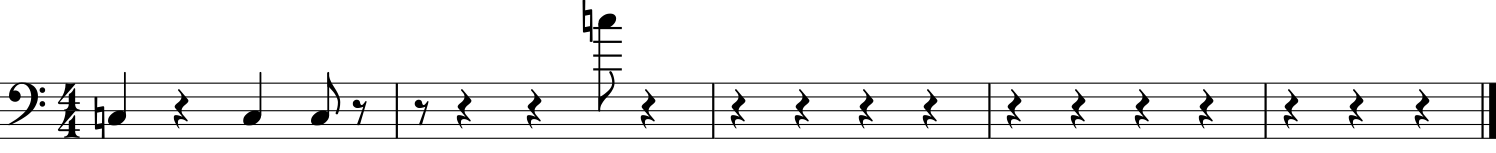

In [43]:
s[:20].show()